# Importing useful libraries and loading input files

In [85]:
#libraries importing

#pd for read doc & dataframe
import pandas as pd
import spacy
#os for files loading
import os
#import re for preprocessing
import re
#import wordcloud to nicely visualise most recurrent words
from wordcloud import WordCloud
#https://towardsdatascience.com/generate-meaningful-word-clouds-in-python-5b85f5668eeb
# importing CountVectorizer to make a bag of words model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
#importing distance metrics to generate a cosine similarity matrix
# importing metrics computing polynomial_kernel with degree=1 and coef0=0
from sklearn.metrics.pairwise import linear_kernel
# importing metrics computing L2-normalized dot product of vectors
from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.metrics.pairwise import cosine_similarity
# tf-idf functionality in sklearn.feature_extraction.text can produce normalized vectors,
# in which case cosine_similarity is equivalent to linear_kernel, only slower.
# source: https://scikit-learn.org/stable/modules/metrics.html

In [ ]:
#models importing

#load only sm
nlp_sm = spacy.load('en_core_web_sm')

In [18]:
# LOADING FILES NB
START_PATH = os.path.dirname(os.getcwd())
NEWS_PATH = os.path.join(START_PATH + r'\assets\news_data.json')
CASE_PATH = os.path.join(START_PATH + r'\assets\case_data.json')
USECASES = os.path.join(START_PATH + r'\data\springboard_ai_usecases.csv')
#added for completeness but not used
ENTITIES_PATH = os.path.join(START_PATH + r'\data\custom_entities.csv')

news: pd.DataFrame = pd.read_json(NEWS_PATH)
news: pd.DataFrame = pd.json_normalize(news['data'])
case: pd.DataFrame = pd.read_json(CASE_PATH)
case: pd.DataFrame = pd.json_normalize(case['data'])

usecases: pd.DataFrame = pd.read_csv(USECASES, delimiter=';', encoding='cp1252')
#usecols=['Usecase Description', 'Type', 'Industry', 'Impact', 'Data Richness'],

# Preprocessing files to help the model

In [53]:
#PREPROCESSING
#taking small sample of 100 just for testing purpose
publications = news.loc[:, ['title','summary', 'text', 'date']].sample(100)
# Remove punctuation
publications['text_processed'] = \
publications['text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
publications['text_processed'] = \
publications['text_processed'].map(lambda x: x.lower())

# importing stopwords from spacy
# additional stopwords should be added to help model processing later
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
# stop word example: https://medium.com/@makcedward/nlp-pipeline-stop-words-part-5-d6770df8a936

# joining into single long text
long_string = ','.join(list(publications.loc[:, 'text_processed'].values))

#extracting named entities to add them to the stopwords later
def get_named_entities(text) -> set:
    doc = nlp_sm(text)
    named_entities = set([ent.text for ent in doc.ents])
    return named_entities

spacy_stopwords.update(get_named_entities(long_string))

# Function to preprocess text
def preprocess(text):
  	# Create Doc object
    # loading nlp keeping standard pipeline #https://spacy.io/usage/processing-pipelines
    # in particular ner to remove names later
    doc = nlp_sm(text, disable=['ner', 'parser'])
    # Generate lemmas
    lemmas = [token.lemma_ for token in doc]
    # Remove stopwords and non-alphabetic characters
    a_lemmas = [lemma for lemma in lemmas
            if lemma.isalpha() and lemma not in spacy_stopwords]
    return ' '.join(a_lemmas)

# Apply preprocess to ted['transcript']
publications['text_processed'] = publications['text_processed'].apply(preprocess)

# Showing two examples
publications.head(2)

,title,summary,text,date,text_processed
1595,Honing household helpers,MIT computer scientists work toward improving ...,Imagine a robot able to retrieve a pile of lau...,2011-05-26,imagine robot able retrieve pile laundry clutt...
277,Report: The public is unconvinced AI will bene...,Decades of sci-fi flicks have instilled a fear...,Decades of sci-fi flicks have instilled a fear...,2019-01-10,sci fi flick instill fear ai people new report...


## Removal of names identified through NER (to be discussed ?)
In theory it should help the model rather than keeping names in the hope that reseachers/companies will
help the model to detect use cases.

# Overview of most common words
Showing most common words in all the documents to identify possible additional words to be added
## Words cloud

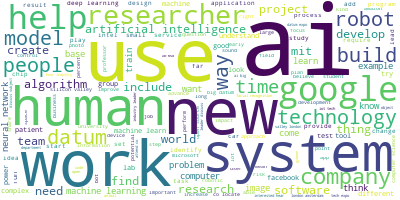

In [54]:
#join all publications into single strings to check most recurrent words in ALL documnets
long_string = ','.join(list(publications.loc[:, 'text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

## Frequency dictionary

In [55]:
# create a dictionary of word frequencies
text_dictionary = wordcloud.process_text(long_string)
# sort the dictionary. reverse starting most common ones
word_freq={k: v for k, v in sorted(text_dictionary.items(),reverse=True, key=lambda item: item[1])}

#use words_ to print relative word frequencies
rel_freq=wordcloud.words_

#print results for top 5
print(r'Absolute frequency', '\n',list(word_freq.items())[:5])
print(r'Relative frequency', '\n', list(rel_freq.items())[:5])

Absolute frequency 
 [('ai', 515), ('use', 260), ('new', 188), ('work', 186), ('system', 180)]
Relative frequency 
 [('ai', 1.0), ('use', 0.5048543689320388), ('new', 0.3650485436893204), ('work', 0.3611650485436893), ('system', 0.34951456310679613)]


## Considerations/Notes
Some names were not removed like: google, zurich, zuckerberg

#NLP modelling

## Building a bag of words model (see [Datacamp](https://campus.datacamp.com/courses/feature-engineering-for-nlp-in-python/n-gram-models?ex=1))
How to implement in a model to be discussed

In [56]:
# Create CountVectorizer object
vectorizer = CountVectorizer()

# Generate matrix of word vectors
bow_matrix = vectorizer.fit_transform(list(publications.loc[:, 'text_processed'].values))

# Convert bow_matrix into a DataFrame
bow_df = pd.DataFrame(bow_matrix.toarray())

# Map the column names to vocabulary
bow_df.columns = vectorizer.get_feature_names()

# Print bow_df
bow_df

,aa,aaa,aaron,abandon,abbeel,abbott,ability,able,abound,absence,...,zergling,zhang,zhukova,zimbabwean,zip,zone,zucchini,zuckerberg,zurich,zzzkbot
0,0,0,0,0,0,0,0,8,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
#printing a few examples
print(f'aa frequency: {bow_df.loc[:,"aa"].sum()}', '\n',
      f'zuckerberg frequency: {bow_df.loc[:,"zuckerberg"].sum()}', '\n',
      f'ai frequency: {bow_df.loc[:,"ai"].sum()}')

aa frequency: 1 
 zuckerberg frequency: 6 
 ai frequency: 610


## Identifying similar articles (see [Datacamp](https://campus.datacamp.com/courses/feature-engineering-for-nlp-in-python/tf-idf-and-similarity-scores?ex=11))

In [87]:
usecase_title = case.iloc[0,1]
usecase_description = case.iloc[0,2]

publications_usecase = publications.loc[:, ['title', 'text_processed']]
publications_usecase.append({'title': usecase_title , 'text_processed': usecase_description}, ignore_index=True)

# Generate mapping between titles and index
# Replacing metadata with news
indices = pd.Series(publications_usecase.index, index=publications_usecase['title']).drop_duplicates()

def get_recommendations(usecase_title, cosine_sim, indices):
    # Get index of publications that matches text_processed
    idx = indices[usecase_title]
    # Sort the movies based on the similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores for 10 most similar publications
    sim_scores = sim_scores[0:11]
    # Get the publications index
    publications_indices = [i[0] for i in sim_scores]
    # Return the top 10 relevant publications
    return publications_usecase['title'].iloc[publications_indices]

# Initialize the TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Construct the TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(publications_usecase.loc[:, 'text_processed'])

# Generate the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix)

# Generate recommendations
print(get_recommendations(usecase_title, cosine_sim, indices))

KeyError: 'Retargeting'

# TO BE CHECKED
BERT classification
TFID